- Executer le pip install
- Restart kernel
- Run all
- Run la map et les formulaires directement ensuite si ils ne s'affichent pas correctement (vérifier l'option d'affichage)

In [25]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# <span style="color:#008080">1. Accroche</span>

> *« Le nombre de lycéens francophones partant étudier à l’étranger après le bac a été **multiplié par quatre** depuis 2020. »*

Cette statistique illustre clairement l’**intérêt grandissant** pour les études internationales. Or, si l'attrait pour les prestigieuses universités américaines est de plus en plus fort, les obstacles restent nombreux : **coûts de scolarité** élevés, **procédures d’admission complexes**, **choix des programmes** parfois déroutants… et les informations manquent souvent de clarté.

**Comment simplifier et démocratiser l’accès à ces opportunités internationales ?** C’est pour répondre à ce défi que nous lançons le projet **Univia**, une plateforme interactive conçue pour éclairer et accompagner chaque candidat dans ses démarches. 

---

# <span style="color:#008080">2. Introduction et Contexte</span>

**Univia** vise à centraliser toutes les informations utiles aux futurs étudiants internationaux, de la sélection des programmes jusqu’aux formalités administratives. Au cœur de cette démarche : l’exploitation de la **donnée** pour mieux comprendre et mieux **recommander**.

<span style="color:#2E8B57">**Ce présent projet**</span> constitue **le premier volet** de l’initiative Univia. Nous allons y collecter et analyser un **ensemble de données** relatives aux universités américaines :  
- Taux d’acceptation  
- Scores requis (SAT, ACT)  
- Coûts de scolarité nets  
- Programmes et filières populaires  

Notre ambition est double :  
1. **Mieux décrypter la sélectivité** et les spécificités de chaque établissement, afin de fournir des informations claires et vérifiées.  
2. **Poser les bases d’un algorithme de recommandation** permettant de suggérer des universités adaptées au profil et aux objectifs de chaque élève.

---

# <span style="color:#008080">3. Pourquoi la Data et l’Analyse sont Cruciales</span>

Dans un contexte où l’information se révèle **fragmentée** (articles de presse, sites officiels, blogs étudiants), **l’analyse de données** s’impose comme un outil puissant pour :

- **Identifier** les tendances et les variables clés (ex. coût, notes requises, programmes les plus demandés).  
- **Comparer** objectivement les établissements en termes de sélectivité, d’aides financières, ou d’atouts académiques.  
- **Orienter** les étudiants vers les meilleures opportunités selon leur profil scolaire, financier et personnel.  

En offrant une **vision agrégée et claire** de toutes ces composantes, nous pouvons déjà lever certains freins à la mobilité. Cette **transparence** est fondamentale pour que chaque élève puisse envisager un projet d’études à l’étranger **en toute connaissance de cause**.

---

# <span style="color:#008080">4. Structure du Projet</span>

Au fil de ce notebook, nous allons :

1. **Collecter** et présenter nos premières données sur les universités américaines *(frais de scolarité, scores SAT/ACT, etc.)*.  
2. **Nettoyer et analyser** ces informations pour mettre en évidence les insights majeurs *(taux d’acceptation, filières phares, répartition géographique, etc.)*.  
3. **Prototyper** un <span style="color:#2E8B57">système de recommandation initial</span> qui, à terme, saura guider chaque utilisateur vers les établissements les plus en phase avec son profil.  

Ce travail servira de **fondation** pour les développements futurs d’Univia, qui s’étendront bientôt aux universités d’autres pays et intégreront de nouvelles fonctionnalités (préparation aux tests, accompagnement administratif, etc.). 

---


# <span style="color:#008080">Installation des dépendances</span>

Pour exécuter correctement le notebook et ses scripts associés, nous installons toutes les librairies nécessaires indiquées dans le fichier `requirements.txt` :

```bash

In [26]:
import pandas as pd
import folium
import numpy as np
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import streamlit as st
import ipywidgets as widgets
import re
import pandas as pd
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import folium
from folium.plugins import MarkerCluster
import requests
import json
import ipywidgets as widgets
from IPython.display import display, clear_output
from branca.element import MacroElement
from jinja2 import Template
import plotly.express as px
import nbformat
import openpyxl
import ipywidgets


# <span style="color:#008080">Data Collection and Preparation</span>

## <span style="color:#2E8B57">DataFrame from Scraped Data</span>

Pour illustrer notre **pipeline de data processing**, nous n’allons afficher que les **5 premières universités** dans ce notebook. Les étapes de collecte et de transformation (telles que `get_coordinates` et `wikiscrapping`) peuvent être assez longues et sont décrites dans les scripts de scraping et l’intégration GPT.  
Ensuite, nous chargerons le **jeu de données complet** (traité et enrichi) afin de poursuivre nos analyses plus approfondies.


In [27]:
# Load data
df = pd.read_excel('universities_data_with_rankings.xlsx').head(5)
df.rename(columns={"Application DeadlineDeadline for application submissions. Please contact the school for more details.":'Application Deadline'}, inplace=True)
df["Net Price"] = df["Net Price"].str.replace("$", "").str.replace(",", "").astype(float)


## <span style="color:#2E8B57">Structure des données</span>

Pour pouvoir **mieux exploiter** les scores SAT, nous transformons la colonne initiale en deux nouvelles colonnes :  
- `low_SAT` (score minimum)  
- `high_SAT` (score maximum)

En parallèle, nous utilisons des **expressions régulières** pour extraire les **trois principaux domaines d’études** (majors) de chaque université, ainsi que le **nombre d’étudiants** inscrits dans ces filières. Ces champs supplémentaires nous aideront à affiner l’analyse de l’offre académique et de la sélectivité.


In [28]:
from preprocessing import apply_extract_sat_range, apply_extract_majors, remove_empty_rows, add_deadline_column

df=add_deadline_column(df, deadline_col='Application Deadline', output_col='Deadline Date', year=2025)


df = remove_empty_rows(df)

# Appliquer la fonction pour extraire SAT Range
df = apply_extract_sat_range(df)

# Appliquer la fonction pour extraire les majors
df = apply_extract_majors(df)

# Afficher les premières lignes
df[['Name', 'City', 'low_sat', 'high_sat',
    'major_top1', 'graduates_top1',
    'major_top2', 'graduates_top2',
    'major_top3', 'graduates_top3']].head()


,Name,City,low_sat,high_sat,major_top1,graduates_top1,major_top2,graduates_top2,major_top3,graduates_top3
0,Massachusetts Institute of Technology,"CAMBRIDGE, MA 02139",1530,1580,Computer Science,384,Mechanical Engineering,142,Mathematics,126
1,Yale University,"NEW HAVEN, CT 06511",1500,1580,Economics,204,Political Science and Government,137,Information Science,104
2,Stanford University,"STANFORD, CA 94305",1500,1580,Computer Science,277,Biology,176,Engineering,168
3,Harvard University,"CAMBRIDGE, MA 02138",1490,1580,Social Science Research Methods,195,Economics,186,Computer Science,173
4,Dartmouth College,"HANOVER, NH 03755",1500,1580,Economics,170,Political Science and Government,153,Computer Science,130


In [29]:
from wiki_scraping import scrape_universities,remove_parentheses_and_brackets,clean_undergraduates


# 2) Appeler la fonction de scraping
df = scrape_universities(df, name_col='Name')

# 3) cleaning 
df['Undergraduates'] = df['Undergraduates'].apply(clean_undergraduates)

cols_to_clean = ['Undergraduates', 'Motto', 'Motto in English', 'Website']
for col in cols_to_clean:
    df[col] = df[col].apply(remove_parentheses_and_brackets)

# 4) Vérifier les nouvelles colonnes
df[['Name', 'Undergraduates', 'Motto', 'Motto in English', 'Website']]


Scraping Wikipedia: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


,Name,Undergraduates,Motto,Motto in English,Website
0,Massachusetts Institute of Technology,4576,Mens et Manus,,mit.edu
1,Yale University,6749,Lux et veritas אורים ותמים,,yale.edu
2,Stanford University,7841,Die Luft der Freiheit weht,,stanford.edu
3,Harvard University,7240,Veritas,,harvard.edu
4,Dartmouth College,4447,Vox clamantis in deserto,,home.dartmouth.edu


## <span style="color:#2E8B57">Unification du Classement (Ranking)</span>

En appliquant la fonction `clean_ranking` sur chaque ligne, nous **harmonisons** les valeurs de classement pour toutes les universités. Le tableau ci-dessous montre un **extrait** après traitement, où la colonne `Ranking` est convertie dans un format **numérique** cohérent. Cette simplification permet de **comparer** plus aisément les différentes institutions et d’envisager des **analyses plus fines** sur leur positionnement. Par exemple, nous excluons les Liberal Art Colleges du classement car ce type d'établissement a un classement distinct et que le classement est rarement un critère de choix pour ce type d'établissement. 
Notons que pour des raisons de simplicitité, nous avons fait appel à l'API ChatGPT pour extraire les classements (approche Most Valuable Product) et que la qualité de l'information n'est pas parfaite. 

In [30]:
from preprocessing import clean_ranking

# Appliquez la fonction clean_ranking
df['Ranking'] = df.apply(clean_ranking, axis=1)

# Affichez les colonnes pertinentes
df[['Name', 'City', 'Ranking']].head()


,Name,City,Ranking
0,Massachusetts Institute of Technology,"CAMBRIDGE, MA 02139",2
1,Yale University,"NEW HAVEN, CT 06511",3
2,Stanford University,"STANFORD, CA 94305",3
3,Harvard University,"CAMBRIDGE, MA 02138",3
4,Dartmouth College,"HANOVER, NH 03755",18


## <span style="color:#2E8B57">Géolocalisation : Latitude et Longitude</span>

Pour **visualiser** et **analyser** nos universités sur une carte, nous avons ajouté deux colonnes : `Latitude` et `Longitude`. Le tableau ci-dessous illustre :

- Des **adresses** parfois manquantes ou incomplètes.  
- Certaines valeurs `NaN` là où le géocodeur n’a pas réussi à déterminer les coordonnées exactes.

Malgré ces petites imperfections, la majorité des universités ont désormais des **coordonnées géographiques** exploitables, permettant de :

1. **Localiser** chaque campus avec précision sur une carte interactive.  
2. **Comparer** les caractéristiques (scores SAT, filières, etc.) en fonction de la **région** ou de l’**environnement** (urbain/rural, climat, etc.).  
3. Approfondir les futures **analyses spatiales** (ex. densité d’établissements hautement sélectifs sur la côte Est, etc.).

Cette intégration de la dimension **géographique** nous fait progresser vers un système de **recommandation plus complet**, où la localité pourra, elle aussi, être prise en compte dans le choix de l’université.


In [31]:
from preprocessing import add_coordinates_to_dataframe

# Ajoutez les coordonnées 
df = add_coordinates_to_dataframe(df, address_col='Address', city_col='City')

# Afficher les colonnes pertinentes
df[['Address', 'City', 'Latitude', 'Longitude']].head()


,Address,City,Latitude,Longitude
0,77 MASSACHUSETTS AVE,"CAMBRIDGE, MA 02139",42.359268,-71.093621
1,133 WALL ST,"NEW HAVEN, CT 06511",41.311677,-72.928227
2,NaN,"STANFORD, CA 94305",46.314475,11.048029
3,MASSACHUSETTS HALL,"CAMBRIDGE, MA 02138",42.374445,-71.118298
4,207 PARKHURST HALL,"HANOVER, NH 03755",NaN,NaN


## <span style="color:#2E8B57">États et Climat</span>

En examinant la colonne `City`, nous avons extrait le **code État** (ex. *MA* pour *Massachusetts*) avant d’y associer un **type de climat** (ex. *Warm*, *Cold*, *Temperate*, *Hot*).  
Le tableau ci-dessous illustre cette correspondance : on constate par exemple que certaines universités se situent dans des régions à **climat chaud** (Texas, Californie) alors que d’autres se trouvent en zones plus **froides** (New Hampshire, Illinois).

Cette information s’avère utile pour :

- **Localiser** rapidement chaque établissement au sein du territoire américain (via l’État).  
- **Enrichir** les critères de recommandation, en tenant compte des préférences climatiques ou du confort géographique de chaque étudiant.  
- **Segmenter** d’éventuelles analyses : comparer la sélectivité, les frais, ou les taux de rétention selon le climat local.

Ainsi, l’ajout des colonnes `State` et `Climate` vient parfaire notre base de données en offrant une **vision plus contextualisée** de chaque université.


In [32]:
from preprocessing import add_state_and_climate

# Ajouter les colonnes 'State' et 'Climate'
df = add_state_and_climate(df, city_col='City')

# Afficher les résultats
print(df[['City', 'State', 'Climate']])


                  City State    Climate
0  CAMBRIDGE, MA 02139    MA  Temperate
1  NEW HAVEN, CT 06511    CT  Temperate
2   STANFORD, CA 94305    CA       Warm
3  CAMBRIDGE, MA 02138    MA  Temperate
4    HANOVER, NH 03755    NH       Cold


## <span style="color:#2E8B57">Création d’un Équivalent de Note Française</span>

Pour faciliter la **comparaison** entre les scores SAT (test d'entrée dans les universités aux États-Unis) et les **notes** plus familières du système français, nous avons mis au point un **proxy** de conversion :  
- Les colonnes `low_grade_adjusted` et `high_grade_adjusted` traduisent ainsi les fourchettes de scores SAT en une **échelle française** (de 0 à 20, ou proche), tout en tenant compte du **taux d’admission**. 
- Cette conversion s'appuie sur la **distribution** des scores du SAT () et des mentions au bac (données de l'éducation nationale)
- Cette conversion est ajustée par la **sélectivité** globale de l’université (`Acceptance Rate`).

En un coup d’œil, on constate que des établissements tels que **Harvard** ou le **MIT** affichent des « notes ajustées » très élevées, soulignant leur niveau d’exigence exceptionnel. Ce nouvel indicateur vise à offrir un **repère clair** pour les élèves et les conseillers pédagogiques habitués au système de notation français, leur permettant de **situer** chaque université dans une grille de lecture plus familière.


In [33]:
%matplotlib inline
import pandas as pd

# Import des fonctions déjà existantes + nouvelles
from sat_processing import (
    full_preprocessing,
    plot_sat_bac_cdf_comparison,
    plot_sat_bac_pdf_comparison
)

# 2) Appliquer la préparation complète
df = full_preprocessing(df)

# 3) Visualiser un aperçu des colonnes intéressantes
df[['Name', 'Acceptance Rate',
          'low_sat', 'high_sat',
          'low_grade_adjusted', 
          'high_grade_adjusted']].head()

,Name,Acceptance Rate,low_sat,high_sat,low_grade_adjusted,high_grade_adjusted
0,Massachusetts Institute of Technology,0.04,1530,1580,18.33,18.75
1,Yale University,0.05,1500,1580,18.05,18.74
2,Stanford University,0.04,1500,1580,18.06,18.75
3,Harvard University,0.03,1490,1580,17.89,18.76
4,Dartmouth College,0.06,1500,1580,18.04,18.73


## <span style="color:#2E8B57">Comparaison SAT vs. Bac</span>

Les graphiques ci-dessous affichent **l’évolution cumulative** (CDF) et **la densité de probabilité** (PDF) pour les scores SAT et les notes du Baccalauréat français :

- **CDF - SAT** (en bleu) : La courbe montre la répartition des scores SAT, suggérant qu’une large majorité d’étudiants obtiennent entre 900 et 1400 points, tandis que seules quelques pointes se situent en deçà de 800 ou au-dessus de 1500.  
- **CDF - Bac** (en vert) : On constate une progression en paliers, caractéristique des notes du Bac (l’évaluation est discontinue, chaque demi-point ou point supplémentaire dans la fourchette 0–20 est facilement identifiable).

En bas, les **PDF** (histogrammes) mettent en évidence :
- **SAT** : Une distribution **gaussienne** relativement centrée (autour de 1050–1100), avec un **étalement** plus ou moins symétrique.  
- **Bac** : Une répartition **asymétrique**, axée sur la tranche 10–15, reflétant la prédominance des notes comprises entre la moyenne (10) et la mention assez bien/bien (12–14).



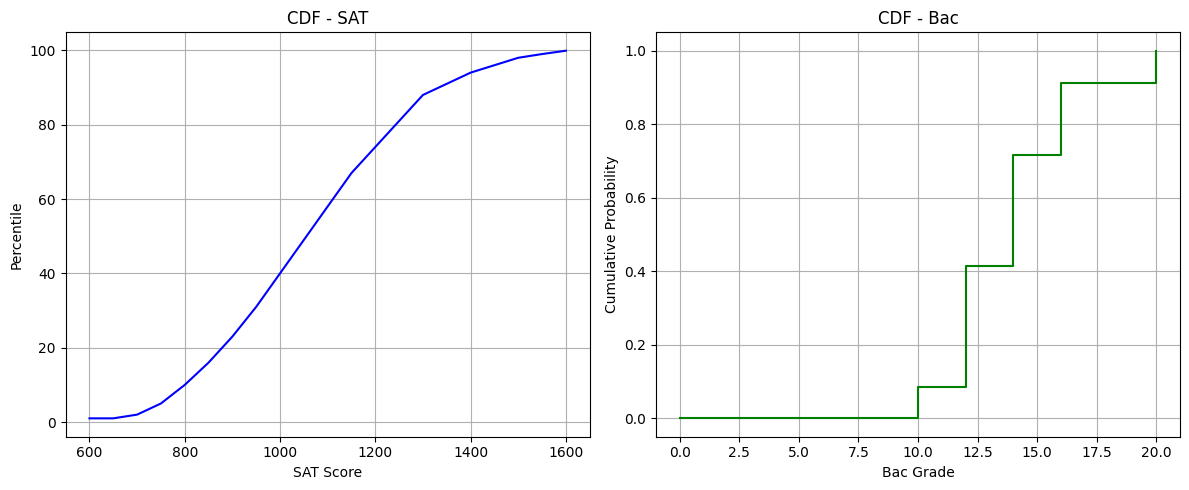

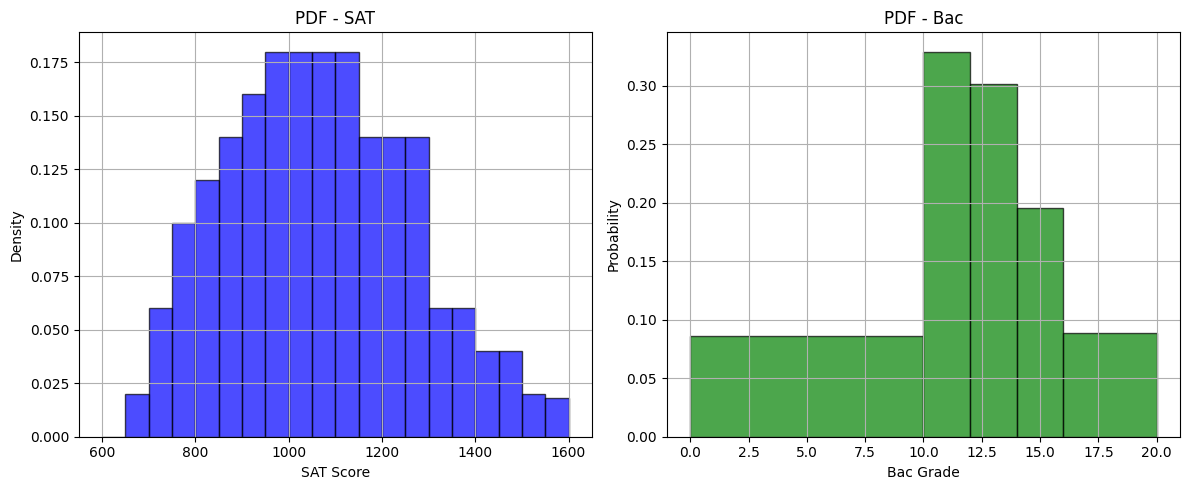

In [34]:
plot_sat_bac_cdf_comparison()
plot_sat_bac_pdf_comparison()

### <span style="color:#008080">Création d’un Proxy : Conversion SAT → Note de Bac</span>

En **superposant** ces distributions, on peut estimer la correspondance entre un score SAT et une **note théorique au Bac**. Cela se fait en considérant :
1. La **forme générale** de chaque distribution (répartition et densité).
2. Les **paliers de mention** au Baccalauréat (10, 12, 14, 16, etc.), croisés avec les **percentiles** du SAT.

Le résultat se matérialise dans nos colonnes :
- `low_grade_adjusted` et `high_grade_adjusted` qui fournissent une **approximation** du niveau de Bac correspondant à la fourchette SAT d’une université, tenant compte aussi de son **taux d’acceptation**. 

Ainsi, un **score SAT élevé** associé à une **faible acceptance rate** peut « équivaloir » à une note supérieure à 15/20, par exemple. À l’inverse, des établissements moins exigeants se traduiront par des « notes de Bac » ajustées plus faibles.  

Cette **conversion** offre un point de repère familier aux élèves et conseillers issus du système français. Elle facilite **l’orientation** et le **positionnement** en comparaison des exigences américaines, contribuant ainsi à rendre les études internationales plus accessibles et mieux comprises.


---

## <span style="color:#2E8B57">Deadline de Candidature et Export</span>

Pour clore cette première phase de préparation, nous avons :
- **Uniformisé les dates limites de candidature** (`Application Deadline`) en les projetant sur l’année 2025, afin de disposer d’un champ homogène (`Deadline Date`).  
- **Exporté** l’ensemble des données enrichies dans `final_dataset_bis.xlsx`, permettant de les **réutiliser** ou de les **mettre à disposition** pour des analyses ultérieures ou l’intégration dans notre futur algorithme de recommandation.  

Nous disposons désormais d’un **jeu de données** complet :  
1. Nettoyé et enrichi (majors, scores SAT, rang d’admission, etc.).  
2. Converti en **référentiels familiers** pour le public français (proxy Bac).  
3. Prêt à être exploré via **des visualisations**, **des statistiques plus approfondies** et, à terme, notre **moteur de recommandation**.


In [35]:
# Ensure 'Application Deadline' is a string
df['Application Deadline'] = df['Application Deadline'].astype(str)

# Function to parse deadlines and set the year to 2025
def parse_deadline(deadline):
    try:
        # Try to parse the date without a year
        date = pd.to_datetime(deadline, format='%B %d')
        # Set the year to 2025
        return date.replace(year=2025)
    except ValueError:
        try:
            # Try parsing with a year (if present)
            date = pd.to_datetime(deadline)
            # Replace the year with 2025
            return date.replace(year=2025)
        except ValueError:
            # If parsing fails, return NaT (Not a Time)
            return pd.NaT

# Apply the function to create a new 'Deadline Date' column
df['Deadline Date'] = df['Application Deadline'].apply(parse_deadline)

# Display the first few rows
df[['Name', 'City', 'Application Deadline', 'Deadline Date']].head()

df.to_excel('test_data_prep.xlsx', index=False)


# <span style="color:#008080">Visualisation des valeurs manquantes :</span>
On visualise ici la proportion de valeurs manquantes (*NaN*) pour plusieurs variables du dataset. Les barres indiquent le pourcentage de *NaN* dans chaque colonne. On remarque notamment :  
- *Undergraduates*, issu du scraping de Wikipédia, est la variable la plus incomplète (taux de *NaN* élevé).  
- *Latitude*, qui dépend de l’adresse (dont *City* est extrait), présente aussi un pourcentage notable de *NaN*.  
- Les autres variables (dont *low_sat*, récupérée depuis *Niche*) ont des proportions de *NaN* plus faibles, même si certaines restent significatives.  

En somme, ce graphique met en évidence les colonnes pour lesquelles il existe le plus de données manquantes et offre un premier aperçu de la qualité globale de chaque source (*Wikipédia*, adresse/coordonnées géographiques, et *Niche*).

In [36]:
# Plot proportion de NaN
from plots import plot_nan_proportions

df = pd.read_excel('final_dataset.xlsx')
cols_to_check = ["Undergraduates", "City", "Latitude",
                 "low_sat", "Application Deadline", "Acceptance Rate"]
plot_nan_proportions(df, cols_to_check)


# <span style="color:#008080">Interactive Mapping</span>

Avec cette étape, nous proposons une **visualisation interactive** de nos universités sur la carte des États-Unis :  
1. Un **curseur (slider)** permettant de filtrer les établissements selon leur **note ajustée** (ou score minimal).  
2. Un **menu déroulant** (dropdown) offrant la possibilité de sélectionner une **catégorie de climat** (Warm, Cold, Temperate, etc.).  

> L’objectif est de **croiser les informations** (scores SAT, climat, etc.) pour mieux repérer les établissements correspondant à un profil précis, et d’**explorer** rapidement les différentes régions et conditions climatiques.

Une fois la carte générée, chaque point (ou cluster) **représente une université**, et un simple survol (ou clic) permet d’afficher les détails de celle-ci (nom, rang d’acceptation, etc.). Grâce à ces filtres interactifs, nous pouvons :

- **Mieux comprendre** l’emplacement géographique des universités les plus sélectives ou les moins coûteuses,  
- **Comparer** l’offre académique selon le **climat** (ex. universités à climat chaud vs. froid),  
- Orienter davantage le choix des étudiants selon leurs **préférences géographiques** et leur **niveau** (notes ou scores).

En synthèse, cette **carte interactive** s’inscrit dans notre démarche de rendre l’expérience plus **intuitive** et **accessible**, permettant à chacun d’effectuer sa propre **exploration** des données avant d’envisager une candidature. 


In [49]:
from map_visualization import create_map_widget

# ---------------------------------------------------------
# 1) Charger ou obtenir le DataFrame déjà préparé
# ---------------------------------------------------------
df = pd.read_excel('final_dataset.xlsx')
df_for_map = df.dropna(subset=['Latitude', 'Longitude'])

# ---------------------------------------------------------
# 2) Définir nos dictionnaires
# ---------------------------------------------------------
state_climate = {
    'AK': 'Cold', 'AL': 'Warm', 'AR': 'Warm', 'AZ': 'Hot', 'CA': 'Warm',
    'CO': 'Cold', 'CT': 'Temperate', 'DE': 'Temperate', 'FL': 'Hot',
    'GA': 'Warm', 'HI': 'Hot', 'IA': 'Cold', 'ID': 'Cold', 'IL': 'Cold',
    'IN': 'Cold', 'KS': 'Temperate', 'KY': 'Temperate', 'LA': 'Hot',
    'MA': 'Temperate', 'MD': 'Temperate', 'ME': 'Cold', 'MI': 'Cold',
    'MN': 'Cold', 'MO': 'Temperate', 'MS': 'Warm', 'MT': 'Cold',
    'NC': 'Temperate', 'ND': 'Cold', 'NE': 'Cold', 'NH': 'Cold',
    'NJ': 'Temperate', 'NM': 'Hot', 'NV': 'Hot', 'NY': 'Temperate',
    'OH': 'Temperate', 'OK': 'Warm', 'OR': 'Temperate', 'PA': 'Temperate',
    'RI': 'Temperate', 'SC': 'Warm', 'SD': 'Cold', 'TN': 'Temperate',
    'TX': 'Hot', 'UT': 'Dry', 'VA': 'Temperate', 'VT': 'Cold',
    'WA': 'Temperate', 'WI': 'Cold', 'WV': 'Temperate', 'WY': 'Cold',
    'DC': 'Temperate'
}

climate_colors = {
    'Cold': '#1f78b4',
    'Temperate': '#33a02c',
    'Warm': '#ff7f00',
    'Hot': '#e31a1c',
    'Dry': '#fdbf6f',
}

# URL du GeoJSON des états US
geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/us-states.json'

# ---------------------------------------------------------
# 3) Créer et afficher les widgets + la carte
# ---------------------------------------------------------
grade_slider, climate_dropdown, map_output = create_map_widget(
    df_for_map=df_for_map, 
    state_climate=state_climate, 
    climate_colors=climate_colors, 
    state_geo=geojson_url
)

# ---------------------------------------------------------
# 4) Afficher les widgets
# ---------------------------------------------------------
display(grade_slider, climate_dropdown)
display(map_output)

IntSlider(value=18, description='Min grade <=', max=18, min=4)

SelectMultiple(description='Climate:', index=(0, 1, 2, 3, 4), options=('Temperate', 'Warm', 'Hot', 'Cold', 'Dr…

Output()

# <span style="color:#008080">Statistiques Descriptives et Visualisation</span>

Nous explorons ici la **relation** entre les **scores SAT bas** (`low_sat`) et **hauts** (`high_sat`), en les corrélant au **taux d’admission** (`Acceptance Rate`). 

- Les cercles sont **colorés** selon leur taux d’admission (de 0% à 100%), offrant un repère immédiat sur la **sélectivité** :  
  - Plus la couleur tend vers le **violet**, plus l’université est **selective** (taux d’acceptation faible).  
  - Plus la couleur tire vers le **jaune**, plus l’établissement est facile d’accès (taux d’acceptation élevé).  

- Une **dispersion** linéaire apparaît nettement : les universités affichant de **plus hauts scores SAT** (ex. 1500+ en score haut) ont **fréquemment** un faible taux d’admission, soulignant leur **haut niveau d’exigence**.

Cette étape de **data visualisation** confirme l’intuition selon laquelle il existe une **corrélation** marquée entre :
1. **Exigences académiques** (scores SAT).  
2. **Sélectivité** (Acceptance Rate).  

Elle constitue un **levier d’information précieux** pour les étudiants qui souhaitent cibler les universités en adéquation avec **leur profil** et pour **mieux comprendre** l’offre académique américaine.


In [38]:
from plots import create_sat_scatter_plot
df = pd.read_excel('final_dataset.xlsx')

# Définir les colonnes de survol
hover_cols = {
    "City": True,
    "Acceptance Rate": ":.0%",
    "Net Price": ":$,.0f",
    "major_top1": True,
    "graduates_top1": True,
}

# Créer et afficher le graphique
fig_sat_scores = create_sat_scatter_plot(
    df,
    x_col="low_sat",
    y_col="high_sat",
    color_col="Acceptance Rate",
    hover_cols=hover_cols,
    title="Low SAT vs High SAT Scores by Acceptance Rate"
)

fig_sat_scores.show()


Le graphique suivant présente un histogramme de la distribution des revenus médians des diplômés 6 ans après leur obtention de diplôme. L'axe des x représente le revenu médian en dollars, tandis que l'axe des y indique le nombre d'universités correspondant à chaque tranche de revenus. On observe les points suivants :  

- La distribution semble suivre une forme approximativement normale, avec un pic autour de **40k à 50k** dollars.  
- Les revenus les plus bas (autour de **10k à 20k**) et les plus élevés (supérieurs à **80k**) sont moins fréquents, formant les extrémités de la courbe.  
- La majorité des universités se regroupent dans la tranche de revenus médians de **30k à 60k**, suggérant une concentration autour de cette moyenne.  

Cette distribution nous pousse à poser la question suivante :  
- Est-ce que les revenus médians 6 ans après la graduation sont corrélés avec le classement des universités ?  
Analyser cette relation pourrait permettre d'explorer si le prestige académique ou les ressources d'une université influencent directement les perspectives salariales de ses diplômés.

In [39]:
from plots import plot_income_histogram
df = pd.read_excel('final_dataset.xlsx')
plot_income_histogram(df, income_col="Median Income 6 Years After Graduation")

L'analyse suivante explore la relation entre le classement universitaire et le salaire médian des diplômés six ans après l'obtention de leur diplôme. Elle vise à comprendre si un classement plus favorable est associé à des salaires plus élevés.

Résultats de la Régression : 

- **Coefficient de régression (pente)** : -70.238
- **Ordonnée à l'origine (intercept)** : 61,761.698
- **R²** : 0.347

Ces résultats indiquent que :

1. Il existe une relation négative entre le classement (un meilleur classement = un chiffre plus petit) et le salaire médian six ans après l'obtention du diplôme.
2. Une augmentation de 1 dans le classement est associée à une diminution moyenne du salaire médian de **70.24 USD**.
3. La valeur de R² montre que **34.7%** de la variance dans les salaires est expliquée par le classement.

Limites de l'Analyse

1. **Causalité** : Cette analyse est corrélationnelle, et non causale. Une corrélation ne signifie pas qu’un meilleur classement cause des salaires plus élevés.
2. **Variables omises** :
   - **Localisation** : Les salaires peuvent varier en fonction de la région (par exemple, New York vs Maryland).
   - **Majors dominantes** : Les universités avec une forte proportion d'étudiants en "business" ou dans des domaines STEM (Sciences, Technologie, Ingénierie, Mathématiques) peuvent afficher des salaires plus élevés, alors que celles avec une proportion importante d'étudiants en arts peuvent avoir des salaires inférieurs.
3. **Variance inexpliquée** : D'autres facteurs, comme les conditions économiques générales ou le réseau des diplômés, ne sont pas pris en compte dans cette analyse.

Bien que le classement universitaire donne une indication sur le salaire médian des diplômés, il est essentiel de tenir compte des variables omises et des limites méthodologiques avant de tirer des conclusions définitives.

In [40]:
from plots import regression_income_vs_ranking
df = pd.read_excel('final_dataset.xlsx')
df_for_plot=df[df['Ranking']<500] # On ne garde que les universités avec un ranking < 500 pour une meilleure visualisation
regression_income_vs_ranking(
    df_for_plot,
    income_col="Median Income 6 Years After Graduation",
    ranking_col="Ranking"
)

Régression : Median Income 6 Years After Graduation ~ Ranking
Coefficient de régression (slope) = -70.238
Ordonnée à l'origine (intercept) = 61761.698
R² = 0.347


# <span style="color:#008080">Analyses Finales et Visualisations Clés</span>

Pour conclure notre exploration, nous avons réalisé plusieurs **analyses visuelles** complémentaires afin de mieux comprendre la **distribution des notes ajustées**, la **popularité des filières**, les **délais de candidature**, et surtout la **relation entre Ranking et Taux d’Acceptance**.

---

## <span style="color:#2E8B57">1. Distribution des Notes Ajustées</span>

Le premier histogramme compare la **Low Adjusted Grade** (en bleu) et la **High Adjusted Grade** (en orange).  
- On constate une répartition relativement groupée entre **8** et **15**, correspondant aux notes françaises **moyennes** à **bonnes**.  
- Une poignée d’universités (en bleu très à gauche) affichent des notes potentiellement **inférieures à 5**, traduisant un **SAT min** très bas ou une **sélectivité** plus faible.

Cette vue d’ensemble nous montre à quel point le **niveau d’exigence** (converti en note du bac) peut varier d’une université à l’autre, et permet aux futurs candidats de **se situer** dans cette échelle.

---

## <span style="color:#2E8B57">2. Principales Filières et Deadlines</span>

### Top Majors
Un second graphique (non illustré ici) met en lumière les **filières les plus populaires** : Computer Science, Economics, Biology… Selon la proportion d’étudiants diplômés, on identifie rapidement les spécialités dominantes dans chaque établissement.

### Deadlines de Candidature
Un autre diagramme (lui aussi optionnellement interactif) met en évidence les **dates limites** (`Application Deadline`) pour postuler, ce qui peut se révéler **crucial** pour les étudiants internationaux souhaitant bien planifier leurs dossiers (tests de langue, essais, etc.).

---

## <span style="color:#2E8B57">3. Ranking vs. Acceptance Rate : “Good Value”</span>

Le dernier graphique illustre la **corrélation** entre le **classement** (Ranking) d’une université et son **taux d’admission** (Acceptance Rate). Une ligne de régression en **rouge** (« Best Fit Line ») met en évidence la **tendance générale** :

- Plus l’université est **classée haut** (Ranking faible) et **sélective** (Acceptance Rate bas), plus elle se situe **au-dessus** de la moyenne en termes d’exigence.  
- À l’inverse, une université **moins bien classée** (Ranking élevé) avec une **forte proportion d’acceptation** se situe **sous** cette tendance.

Le critère **`good_value = True`** (points en **vert**) met en avant celles qui **surperforment** par rapport à la **prédiction** de la régression (au-delà d’un certain **seuil** paramétrable, par exemple 50 places de différence). En d’autres termes, ce sont des universités offrant un **excellent ratio** entre **ranking** et **taux d’admission**, potentiellement intéressantes pour des candidats en quête de **bon compromis** entre prestige et compétitivité.

> **Note** : Les *Liberal Arts Colleges* (LAC) sont exclus de cette comparaison, car ils ont leurs **propres critères de classement** et proposent souvent un contexte ou une taille d’établissement très particulier (certaines LAC sont réservées à un genre, spécialisées dans un sport, etc.).



Le graphique suivant est interactif et l'on peut afficher uniquement low ou high en cliquant directement sur la légende. 

In [41]:
from plots import plot_adjusted_grades_histogram
df = pd.read_excel('final_dataset.xlsx')


try:
    fig_adjusted_grades = plot_adjusted_grades_histogram(df)
    fig_adjusted_grades.show()
except ValueError as e:
    print(e)


In [42]:
from plots import plot_top_majors

# Plot the chart
plot_top_majors(df, max_majors=20)

In [43]:
from plots import plot_application_deadlines
df = pd.read_excel('final_dataset.xlsx')


# Plot the application deadlines
plot_application_deadlines(df)

Le graphique suivant est interactif et l'on peut afficher ou pas la droite de régression, les good_values, et les autres en cliquant sur la légende.

In [44]:
from plots import analyze_ranking_vs_acceptance

df = pd.read_excel('final_dataset.xlsx')
df_for_ranking_analysis=df[df["LAC"] == 0]
df_for_ranking_analysis=df_for_ranking_analysis[df_for_ranking_analysis["Ranking"]<500] 

# 2) Appeler la fonction d'analyse
fig = analyze_ranking_vs_acceptance(df_for_ranking_analysis, ranking_threshold=50)

# 3) Afficher le graphique
fig.show()

---

## <span style="color:#2E8B57">Conclusion</span>

Grâce à ces dernières visualisations :

1. Nous **approfondissons** la notion de sélectivité via la comparaison **Ranking vs. Acceptance Rate**.  
2. Nous **mettons en évidence** les filières phares et les opportunités (ou contraintes) en matière de **dates limites**.  
3. Nous donnons une **lecture complémentaire** aux étudiants internationaux pour **identifier** les universités à bon potentiel (« Good Value ») et évaluer **l’écart** entre leurs scores/notes et l’exigence attendue.

Ce **tour d’horizon analytique** s’inscrit parfaitement dans la démarche **Univia** : démocratiser l’accès à l’information et fournir les **outils** pour que chacun puisse **orienter** ses choix de façon **éclairée**.


# <span style="color:#008080">Analyse de Clustering par PCA</span>

Pour affiner notre compréhension des universités et dégager des **profils** ou **typologies** d’établissements, nous avons mis en place un **clustering** (K-Means) couplé à une **analyse en composantes principales** (PCA).

---

## <span style="color:#2E8B57">1. Choix du Nombre de Clusters</span>

La **méthode du coude** (*Elbow Method*) nous aide à repérer la valeur de *k* (nombre de clusters) la plus pertinente.  
- Au-delà d’un certain point, la réduction d’**inertie** se fait plus faible, suggérant qu’ajouter plus de clusters n’apporte plus de réelle valeur analytique.

Dans notre cas, on observe un fléchissement net entre *k=3* et *k=4*, ce qui justifie l’**utilisation d’au moins 4 clusters** pour mieux distinguer les groupes d’universités.

---

## <span style="color:#2E8B57">2. Poids et Données Prises en Compte</span>

Nous avons intégré à la fois :
- Des **variables numériques** (scores SAT, taux d’admission, Net Price, etc.).  
- Des **variables catégorielles** (ville, climat, principales filières).  

Avec un **jeu de poids** ajustable pour refléter l’importance perçue de chaque attribut (ex. *Latitude, Longitude* pondérés à 0.5 contre 1.0 pour la plupart des indicateurs académiques).

---

## <span style="color:#2E8B57">3. Projection PCA</span>

La PCA (Analyse en Composantes Principales) nous permet de **visualiser** dans un espace bidimensionnel (PC1 et PC2) la répartition des universités. Chaque point correspond à une université, coloré selon son **cluster K-Means** (0, 1, 2, 3).

- Les **vecteurs de charges** (Loadings) indiquent dans quelle mesure chaque variable contribue à la création des composantes principales (ex. `low_sat` et `high_sat` ont un impact significatif sur PC1).  
- Sur la figure, on distingue nettement **4 nuages** de points, suggérant des groupes aux caractéristiques communes (frais, sélectivité, localisation, etc.).

---

## <span style="color:#2E8B57">4. Interprétation des Clusters</span>

Chaque **cluster** regroupe des universités partageant des **profils similaires**. Par exemple :
- **Cluster 0** : Établissements avec Net Price élevé mais acceptation faible, dominés par les filières en sciences.  
- **Cluster 1** : Universités plus abordables financièrement, dans des zones géographiques chaudes, etc.  
- **Cluster 2** : Grandes écoles très sélectives avec SAT élevé (Ivy League, Stanford, MIT…).  
- **Cluster 3** : Campus offrant un compromis moyen entre sélectivité et coûts, etc.

> Les exemples ci-dessus sont hypothétiques : l’analyse précise dépendra des caractéristiques réelles de vos données et des **centroïdes** calculés par l’algorithme.

---

## <span style="color:#2E8B57">5. Apports pour Univia</span>

Cette segmentation offre plusieurs **pistes** pour améliorer le **système de recommandation** :
1. **Personnalisation** : Proposer à un étudiant de cibler préférentiellement un cluster en phase avec son niveau scolaire, son budget et ses préférences climatiques.  
2. **Découverte** : Permettre à l’utilisateur de *“sortir”* de son cluster potentiel s’il souhaite viser un univers plus compétitif ou, au contraire, plus accessible.  
3. **Compréhension** : Illustrer de façon visuelle les différences entre groupes d’universités (taille, sélectivité, localisation).

En somme, ce **clustering** apporte une **dimension exploratoire** précieuse, mettant en relief de véritables **profils d’établissements** et aidant à construire un **algorithme d’orientation** plus précis et plus **adapté** à chaque étudiant.


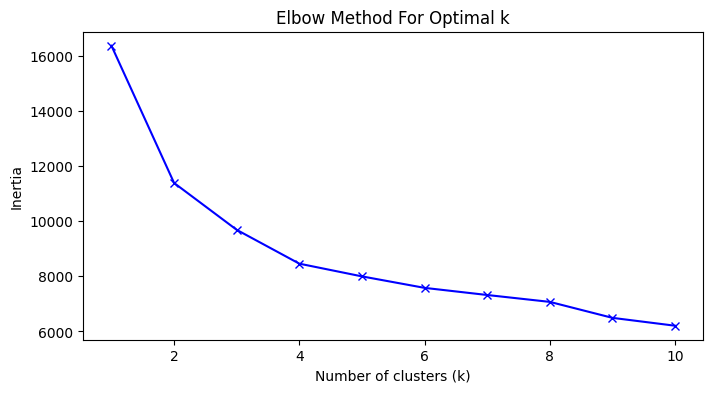

DataFrame with Clusters:
                                    Name  cluster_kmeans
0  Massachusetts Institute of Technology               2
1                        Yale University               2
2                    Stanford University               2
3                     Harvard University               2
4                      Dartmouth College               2

PCA Loadings:
                          PC1       PC2
low_sat              0.338471 -0.028067
high_sat             0.336779 -0.023357
Acceptance Rate     -0.230232  0.050881
Net Price            0.167759 -0.251038
graduates_top1       0.064893  0.542649
graduates_top2       0.072923  0.562317
graduates_top3       0.079439  0.553210
Latitude             0.018193 -0.053446
Longitude            0.021532 -0.020996
low_percentile       0.335818 -0.022433
high_percentile      0.310378 -0.018207
low_grade            0.334014 -0.032095
high_grade           0.337438 -0.023250
low_grade_adjusted   0.333760 -0.034604
high_grade_adjuste

In [45]:
%matplotlib inline

from clustering_analysis import perform_clustering_analysis
df = pd.read_excel('final_dataset.xlsx')

# 2) Définir les colonnes numériques et catégorielles
numerical_cols = [
    'low_sat', 'high_sat', 'Acceptance Rate', 'Net Price', 'graduates_top1',
    'graduates_top2', 'graduates_top3', 'Latitude', 'Longitude', 
    'low_percentile', 'high_percentile', 'low_grade', 'high_grade', 
    'low_grade_adjusted', 'high_grade_adjusted', 'Ranking'
]
categorical_cols = [
    'City', 'State', 'Climate', 'major_top1', 'major_top2', 'major_top3'
]

# 3) Définir vos poids
weights = {
    'low_sat': 1.0,
    'high_sat': 1.0,
    'Acceptance Rate': 1.0,
    'Net Price': 1.0,
    'graduates_top1': 1.0,
    'graduates_top2': 1.0,
    'graduates_top3': 1.0,
    'Latitude': 0.5,
    'Longitude': 0.5,
    'low_percentile': 1.0,
    'high_percentile': 1.0,
    'low_grade': 1.0,
    'high_grade': 1.0,
    'low_grade_adjusted': 1.0,
    'high_grade_adjusted': 1.0,
    'Ranking': 1.0,
    'City': 0.5,
    'State': 0.5,
    'Climate': 0.5,
    'major_top1': 1.0,
    'major_top2': 1.0,
    'major_top3': 1.0
}

# 4) Appeler la fonction
df_result, fig_pca, pca_loadings = perform_clustering_analysis(
    df=df,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    weights=weights,
    k=4,             # Nombre de clusters
    show_elbow=True  # Afficher la courbe Elbow Method
)

# 5) Visualiser le résultat
print("DataFrame with Clusters:")
print(df_result[['Name', 'cluster_kmeans']].head())  # par exemple

print("\nPCA Loadings:")
print(pca_loadings)

# 6) Afficher la figure interactive
fig_pca.show()


# Si le Elbow graph ne s'affiche pas, cliquer sur les ... et changer l'option d'affichage.

## <span style="color:#2E8B57">Fonctionnalités Supplémentaires</span>

### 1. Sélection Multiple d’Universités
Pour rendre l’interface plus conviviale, nous avons ajouté la possibilité de **sélection multiple** :  
- Maintenez la touche <kbd>Ctrl</kbd> (ou <kbd>Command</kbd> sur Mac) enfoncée,  
- Cliquez sur les **universités** qui vous intéressent dans la liste,  
- Vous pouvez ainsi composer une **short list** de campus à comparer ou à intégrer dans votre plan d’étude.

### 2. Génération d’un *Study Plan*
Une fois votre sélection réalisée, un **générateur de plan d’étude** (« Study Plan ») vous permet de planifier :  
- **Les tâches et objectifs** (préparer l’essai, finaliser la lettre de motivation, etc.),  
- **Les plages de révision** (pour le SAT, les cours, etc.).

Cette fonctionnalité aide à **structurer** votre parcours de candidature et à **anticiper** les étapes importantes.

### 3. Export du Calendrier
Enfin, pour **faciliter la gestion du temps**, vous pouvez **exporter** votre Study Plan au format **.ics** :  
- Ce fichier est **compatible** avec la plupart des applications de calendrier (Apple Calendar, Google Agenda, Outlook…).  
- Après import, vous retrouvez toutes vos **tâches** et **échéances** directement intégrées à votre agenda.  

En centralisant ces informations (choix des universités, dates limites, tâches à accomplir), nous rendons le processus de candidature **plus fluide** et **mieux organisé**, répondant ainsi à l’objectif d’Univia : **optimiser** et **simplifier** la mobilité étudiante à l’international.


In [46]:
from study_plan import create_study_planner
df = pd.read_excel('final_dataset.xlsx')

create_study_planner(df)

# <span style="color:#008080">Formulaire pour l'Algorithme de Recommandation</span>

Dans cette section, nous présentons le **formulaire** permettant de recueillir les informations essentielles sur chaque étudiant et d’alimenter notre **algorithme de recommandation**.  
L’objectif est de **matcher** au mieux les préférences et le profil scolaire de l’utilisateur avec les caractéristiques des universités contenues dans notre *dataset*.

---

Le formulaire comporte différentes **catégories de questions** visant à renseigner :  
- Les **données personnelles** (nom, âge, etc.)  
- Les **choix académiques** (majeure, mineure, centres d’intérêt)  
- Les **critères financiers et pratiques** (budget, localisation souhaitée)  
- Les **scores** (GPA, SAT, ACT)  
- Les **préférences** quant à la vie de campus, la recherche, la diversité, etc.  
- Le **niveau de risque** et **d’ambition** pour cibler des universités plus ou moins sélectives  
- Le **style de recommandation** (découverte, similaire, etc.)

En collectant ces données, nous pouvons **relier** les besoins et aspirations de l’étudiant aux informations de notre base (ex. scores requis, Net Price, majors proposées). L’objectif est de **maximiser** les chances de trouver une université à la fois adaptée et réaliste.

### <span style="color:#FF6347">Pourquoi demander ces informations ?</span>

1. **Majors & Intérêts** : Connaître les domaines de prédilection pour proposer des établissements dont les filières dominantes correspondent à ces intérêts.  
2. **Budget** : Vérifier la **compatibilité financière** avec le *Net Price* et les possibilités de bourses.  
3. **Scores Académiques** : Évaluer la **faisabilité** de l’admission (SAT/ACT, GPA).  
4. **Préférences Géographiques et Campus** : Certaines universités ont des spécificités (climat, vie sur le campus…) qui peuvent constituer un critère déterminant.  
5. **Niveau de Risque & d’Ambition** : Aide à définir le **niveau de sélectivité** à viser.  
6. **Style de Recommandation** : Permet d’introduire ou non de la **diversification** afin de suggérer des universités hors des critères stricts, ou au contraire, un matching plus rigoureux.



In [47]:
# main_notebook.ipynb (exemple)

from formulaire import display_form

# Exécutez cette cellule pour afficher le formulaire
display_form()


---




# <span style="color:#008080">Algorithme de Recommandation</span>

Notre **algorithme** se propose de faire matcher au mieux **les préférences** de l’étudiant, récoltées via le formulaire, avec les **caractéristiques** des universités présentes dans notre dataset.  

---
## <span style="color:#2E8B57">1. Objectif</span>

L’objectif principal de cet algorithme de recommandation est de **fournir** à l’utilisateur une **liste** d’établissements (environ 8 à 12) qu’il pourra **approfondir**, en considérant :
- **Leurs exigences académiques** (scores SAT/ACT, sélectivité, etc.)  
- **Les contraintes budgétaires** (Net Price)  
- **Les domaines d’études** (majors, centres d’intérêt)  
- **La localisation** (région, climat, vie de campus...)  
- **Les préférences plus subjectives** (niveau de risque, diversification, etc.)

---
## <span style="color:#2E8B57">2. Données Entrantes</span>

1. **Réponses du Formulaire** (`reponses_formulaire.xlsx`)  
   - *Majeure*, *intérêts académiques*, *budget*, *score SAT*, *mode de recommandation*, etc.  

2. **Dataset des Universités** (`final_dataset.xlsx`)  
   - *Scores SAT requis*, *taux d’acceptation*, *Net Price*, *majors les plus populaires* (`major_top1`, etc.), *localisation*…

Ces **deux sources** sont indispensables au **calcul** d’un **score de fitting** pour chaque université.

---
## <span style="color:#2E8B57">3. Calcul du Score de Fitting</span>

### <span style="color:#FF6347">a) Correspondance des Majors</span>
Nous évaluons le **degré de matching** entre :  
- Les **majors** sélectionnées par l’étudiant,  
- Les **majors principales** de l’établissement (`major_top1`, `major_top2`, `major_top3`).  
Plus le nombre de correspondances est élevé, plus la **compatibilité** se voit augmentée.

### <span style="color:#FF6347">b) Contrainte Budgétaire</span>
Nous comparons le **Net Price** de l’université au **budget** annoncé par l’utilisateur.  
- Si l’université est **en-deçà** du budget, le score s’améliore.  
- Au-dessus du budget, la compatibilité diminue.

### <span style="color:#FF6347">c) Scores SAT/ACT</span>
Nous évaluons si le **score** de l’utilisateur se situe dans la **fourchette** `[low_sat, high_sat]`.  
- Score **nettement supérieur** : hausse de la probabilité d’admission (impact positif).  
- Score **trop bas** : ajustement à la baisse du score de fitting.

### <span style="color:#FF6347">d) Mode de Recommandation</span>
- **Mode Découverte** : Ajoute un **facteur aléatoire** pour proposer des universités moins attendues.  
- **Mode Similaire** : Recommandations plus proches des critères exacts.  
- **Très similaires** : Filtrage strict autour des paramètres de l’étudiant.

### <span style="color:#FF6


In [48]:
# main_notebook.ipynb

from algo_reco import run_recommendation

# Lancer la recommandation (après avoir rempli le formulaire et généré 'reponses_formulaire.xlsx')
recommended_df = run_recommendation(
    dataset_path="final_dataset.xlsx",
    user_responses_path="reponses_formulaire.xlsx",
    nb_min=8,
    nb_max=12
)

# Afficher les résultats
display(recommended_df)


,Name,City,Score_Fitting
0,Stanford University,"STANFORD, CA 94305",3.8
1,Harvey Mudd College,"CLAREMONT, CA 91711",3.8
2,Massachusetts Institute of Technology,"CAMBRIDGE, MA 02139",3.3
3,Cornell University,"ITHACA, NY 14853",3.3
4,California Institute of Technology,"PASADENA, CA 91125",3.3
5,Carnegie Mellon University,"PITTSBURGH, PA 15213",3.3
6,Tufts University,"MEDFORD, MA 02155",3.3
7,Pomona College,"CLAREMONT, CA 91711",3.3
8,Washington University in St. Louis,"SAINT LOUIS, MO 63130",3.3
9,Middlebury College,"MIDDLEBURY, VT 05753",3.3


# <span style="color:#008080">Conclusion Générale</span>

Au travers de cette analyse et de ce développement, nous avons :

1. **Défini le contexte** d’**Univia**, plateforme visant à centraliser et démocratiser l’accès aux études internationales.  
2. **Collecté** et **préparé** un grand volume de données issues de différents canaux (scraping, API GPT, Wikipédia), afin de disposer d’un **jeu de données nettoyé et enrichi** (scores SAT, coûts, majors, etc.).  
3. **Exploré** ces données via diverses **analyses visuelles et statistiques** (cartographie interactive, corrélation entre scores SAT et taux d’admission, distribution des notes, etc.).  
4. **Mis en place** un **formulaire** d’orientation permettant de **recueillir** les informations clés de chaque étudiant (majeure, budget, scores estimés, etc.).  
5. **Implémenté** un **algorithme de recommandation** basique, utilisant un **score de fitting** pour suggérer à l’étudiant une liste d’universités adaptées à ses besoins et aspirations.

### <span style="color:#FF6347">Points saillants</span>
- La **sélectivité** des universités américaines peut être appréhendée grâce à la **fourchette SAT**, les **taux d’acceptation** et des indicateurs comme le **ranking**.  
- Le **budget** (Net Price) se révèle déterminant pour l’orientation : un **mauvais ciblage** peut conduire à des démarches d’admission peu réalistes.  
- Les **spécificités géographiques** (climat, localisation urbaine/rurale) et l’**ADN académique** (majors dominantes) permettent d’aller **au-delà** du simple critère “prestige”.  
- Le **moteur de recommandation** apporte une **approche intégrée**, mettant en relation **scores** et **préférences** de l’étudiant avec les **données contextualisées** de chaque établissement.

### <span style="color:#2E8B57">Perspectives</span>
- **Affiner** l’algorithme de recommandation en intégrant davantage de variables (qualité de vie, retours d’anciens étudiants, dispositifs de bourses…).  
- **Étendre** l’approche à d’autres pays et universités, permettant une **comparaison internationale**.  
- Développer des **fonctionnalités** plus avancées : alertes d’échéances, conseils interactifs (coach IA), suivi du **dossier de candidature**…

En définitive, ce **projet** illustre la capacité des approches **data-driven** et de l’**IA** à **réduire** les obstacles à la mobilité étudiante et à **personnaliser** l’orientation, dans le but de **maximiser** la réussite et l’épanouissement académique de chaque futur candidat.
